<a href="https://colab.research.google.com/github/bethuunltd/Weather-Prediction/blob/main/BlizzardForecastIntegrated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt

In [ ]:
pip install vmdpy


In [ ]:
class Param_LSTM(nn.Module):
  def __init__(self,input_size = 1,hidden_size = 50,num_layers = 2):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size,hidden_size,num_layers,batch_first=True)
    self.fc = nn.Linear(hidden_size,1)

  def forward(self,x):
    h0 = torch.zeros(self.num_layers,x.size(0),self.hidden_size)
    c0 = torch.zeros(self.num_layers,x.size(0),self.hidden_size)
    out,_ = self.lstm(x,(h0,c0))
    out = self.fc(out[:,-1,:])
    return out


class Blizzard_LSTM(nn.Module):
  def __init__(self, input_size =2,hidden_size = 64,num_layers = 2):
    super().__init__()
    self.input_size = input_size
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size = 2, hidden_size =64, num_layers = 2,batch_first=True)
    self.fc = nn.Linear(in_features = 64, out_features = 1)



  def forward(self,x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size,device = x.device)
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size,device = x.device)
    out,_ = self.lstm(x,(h0,c0))
    out = self.fc(out[:,-1,:])
    return out

#===============================================================================================================
#IGNORE THIS CLASS DEFINITION FOR THE BLIZZARD
#===============================================================================================================
class CNN_LSTM(nn.Module):
    def __init__(self, input_size=1, cnn_filters=56, kernel_size=3,
                 hidden_size=64, num_layers=2, horizon=5, dropout=0.3):
        super(CNN_LSTM, self).__init__()
        self.horizon = horizon
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.cnn = nn.Conv1d(in_channels=input_size,
                             out_channels=cnn_filters,
                             kernel_size=kernel_size,
                             padding=kernel_size // 2)#Kernel size padding looks back and forth from
        self.relu = nn.ReLU()
        self.cnn_dropout = nn.Dropout(p=dropout)

        self.lstm = nn.LSTM(input_size=cnn_filters,
                            hidden_size=hidden_size,
                            num_layers=num_layers,
                            batch_first=True,
                            dropout=dropout)

        self.fc_dropout = nn.Dropout(p=dropout)
        self.fc = nn.Linear(hidden_size, horizon * input_size)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, features, time)
        x = self.relu(self.cnn(x))
        x = self.cnn_dropout(x)
        x = x.permute(0, 2, 1)  # (batch, time, features)

        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size, device=x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc_dropout(out[:, -1, :])
        out = self.fc(out)
        out = out.view(-1, self.horizon, self.input_size)
        return out
# === [NEW] CNN + BiLSTM Blizzard Model ===
#USE THE BELOW CLASS DEFINITION FOR THE BLIZZARD
class CNN_BiLSTM_Blizzard(nn.Module):
    def __init__(self, input_size=2, cnn_out_channels=32, lstm_hidden_size=64, lstm_layers=1, kernel_size=3):
        super().__init__()
        self.input_size = input_size

        # CNN expects (batch, channels, seq_len), so treat features as channels
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=cnn_out_channels, kernel_size=kernel_size, padding=1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

        # BiLSTM layer
        self.bilstm = nn.LSTM(input_size=cnn_out_channels, hidden_size=lstm_hidden_size,
                              num_layers=lstm_layers, batch_first=True, bidirectional=True)

        # Fully connected output layer
        self.fc = nn.Linear(in_features=lstm_hidden_size * 2, out_features=1)  # bidirectional

    def forward(self, x):
        # Input x: (batch, seq_len, features)
        x = x.permute(0, 2, 1)  # -> (batch, features, seq_len) for Conv1d
        x = self.conv1(x)       # -> (batch, cnn_out_channels, seq_len)
        x = self.relu(x)
        x = self.dropout(x)

        x = x.permute(0, 2, 1)  # -> (batch, seq_len, cnn_out_channels)
        out, _ = self.bilstm(x) # -> (batch, seq_len, hidden_size*2)
        out = out[:, -1, :]     # take the last time step

        out = self.fc(out)      # -> (batch, 1)
        return out  # raw logits


In [ ]:
#A separate cell for the BEST ws modellllllllll
class Encoder(nn.Module):
  def __init__(self,input_dim,hidden_dim,num_layers=1):
    super().__init__()
    self.hidden_dim = hidden_dim
    self.num_layers = num_layers
    self.input_dim = input_dim
    self.lstm = nn.LSTM(input_dim,hidden_dim,num_layers,batch_first=True)

  def forward(self,x):
    outputs,(h_n,c_n) = self.lstm(x)
    return outputs,h_n,c_n

class BahdanauAttention(nn.Module):
    def __init__(self, enc_hidden_dim, dec_hidden_dim):
        super().__init__()
        self.attn = nn.Linear(enc_hidden_dim + dec_hidden_dim, dec_hidden_dim)
        self.v = nn.Linear(dec_hidden_dim, 1, bias=False)

    def forward(self, decoder_hidden, encoder_outputs):
        batch_size = encoder_outputs.size(0)
        src_len = encoder_outputs.size(1)

        decoder_hidden = decoder_hidden[-1].unsqueeze(1).repeat(1, src_len, 1)
        concat = torch.cat((encoder_outputs, decoder_hidden), dim=2)

        energy = torch.tanh(self.attn(concat))
        attention = self.v(energy).squeeze(2)
        return torch.softmax(attention, dim=1)


class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, num_layers=1):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.output_dim = output_dim

        self.attention = BahdanauAttention(hidden_dim, hidden_dim)
        self.lstm = nn.LSTM(output_dim + hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, hidden, cell, encoder_outputs):
        # x: (batch, 1, output_dim)
        attn_weights = self.attention(hidden, encoder_outputs)  # (batch, seq_len)
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)  # (batch, 1, hidden_dim)

        lstm_input = torch.cat((x, context), dim=2)  # (batch, 1, output_dim + hidden_dim)
        outputs, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))
        prediction = self.fc(outputs)
        return prediction, hidden, cell




class Seq2Seq(nn.Module):
  def __init__(self,encoder,decoder,device):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.device = device

  def forward(self,src,target_len,target_seq = None,teacher_forcing_ratio = 0.5):
    batch_size, seq_len, _ = src.size()
    outputs = []

    encoder_outputs,hidden,cell = self.encoder(src)
    input_decoder = src[:, -1:, :2]  #The last know value of windspeed(at hour 24) - Becomes the input for the decoder




    for t in range(target_len):
      output, hidden, cell = self.decoder(input_decoder, hidden, cell, encoder_outputs)
      outputs.append(output)


      if target_seq is not None and torch.rand(1).item () < teacher_forcing_ratio:
        input_decoder = target_seq[:,t:t+1,:] #This is the ground truth input
      else:
        input_decoder = output

    return torch.cat(outputs,dim=1) #Final shape: (batch_size, target_len, output_dim)


In [ ]:
df = pd.read_csv('data.csv',parse_dates=['date'])
df.set_index('date',inplace= True)
ap = df[['ap']].values
ws = df[['ws']].values
blizzard = df[['blizzard']].values

#----------------------------------FOR THE BLIZZARD POS_WT-----------------------------------------------
feature_names = ['ap','ws']
target = 'blizzard'
features = df[feature_names]
labels = df[target]
train_size = 0.70
valid_size = 0.20
test_size = 0.10
train_labels = labels[:int(train_size*len(labels))]

In [ ]:
import torch.nn as nn

class VMDEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

    def forward(self, x):
        outputs, (hidden, cell) = self.lstm(x)
        return outputs, hidden, cell

class VMDAttention(nn.Module):
    def __init__(self, enc_hidden_dim, dec_hidden_dim):
        super().__init__()
        self.attn = nn.Linear(enc_hidden_dim + dec_hidden_dim, dec_hidden_dim)
        self.v = nn.Linear(dec_hidden_dim, 1, bias=False)

    def forward(self, decoder_hidden, encoder_outputs):
        batch_size, seq_len, enc_dim = encoder_outputs.shape
        decoder_hidden = decoder_hidden[-1].unsqueeze(1).repeat(1, seq_len, 1)
        energy = torch.tanh(self.attn(torch.cat((decoder_hidden, encoder_outputs), dim=2)))
        attn_weights = torch.softmax(self.v(energy).squeeze(2), dim=1)
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)
        return context

class VMDDecoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, num_layers=2):
        super().__init__()
        self.attention = VMDAttention(hidden_dim, hidden_dim)
        self.lstm = nn.LSTM(output_dim + hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, hidden, cell, encoder_outputs):
        context = self.attention(hidden, encoder_outputs)
        lstm_input = torch.cat((x, context), dim=2)
        outputs, (hidden, cell) = self.lstm(lstm_input, (hidden, cell))
        prediction = self.fc(outputs)
        return prediction, hidden, cell

class VMDSeq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, target_len, target_seq=None, teacher_forcing_ratio=0.5):
        batch_size, _, input_dim = src.size()
        outputs = []

        encoder_outputs, hidden, cell = self.encoder(src)
        input_decoder = src[:, -1:, :]

        for t in range(target_len):
            output, hidden, cell = self.decoder(input_decoder, hidden, cell, encoder_outputs)
            outputs.append(output)

            if target_seq is not None and torch.rand(1).item() < teacher_forcing_ratio:
                input_decoder = target_seq[:, t:t+1, :]
            else:
                input_decoder = output

        return torch.cat(outputs, dim=1)

In [ ]:
ap_forecast_model = Param_LSTM()
ap_forecast_model.load_state_dict(torch.load('AirPressure Prediction LSTM (1)'))

#ws_forecast_model = CNN_LSTM()
#ws_forecast_model.load_state_dict(torch.load('windspeed CNNLSTM.pt'))
#-----------------------------------------------------------------------------------------

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Model instantiation
#encoder = Encoder(input_dim=6, hidden_dim=64, num_layers=2)
#decoder = Decoder(output_dim=2, hidden_dim=64, num_layers=2)
#ws_forecast_model  = Seq2Seq(encoder=encoder, decoder=decoder, device=device).to(device)
#ws_forecast_model.load_state_dict(torch.load('windspeed.pt'))
#-----------------------------------------------------------------------------------------


blizzard_prediction_model = CNN_BiLSTM_Blizzard()
blizzard_prediction_model.load_state_dict(torch.load('CNNLSTM_threshold.pt'))

criterion_ap = nn.MSELoss()
criterion_ws = nn.MSELoss()



num_pos = train_labels.sum()
num_neg = len(train_labels) - num_pos
pos_wt = torch.tensor(num_neg / num_pos)
criterion_blizzard = nn.BCEWithLogitsLoss(pos_wt)

In [ ]:
from vmdpy import VMD
from torch.utils.data import Dataset, DataLoader

# Load raw windspeed
ws_series = df['ws'].values.flatten()

def apply_vmd(series, alpha=2000, tau=0, K=5, DC=0, init=1, tol=1e-7):
    u, _, _ = VMD(series, alpha, tau, K, DC, init, tol)
    return u.T  # shape: (len, K)

vmd_modes = apply_vmd(ws_series, K=5)

n = len(vmd_modes)
train_size = 0.7
valid_size = 0.2

train_data_vmd = vmd_modes[:int(train_size * n)]
val_data_vmd = vmd_modes[int(train_size * n):int((train_size + valid_size) * n)]
test_data_vmd = vmd_modes[int((train_size + valid_size) * n):]

class VMDDataset(Dataset):
    def __init__(self, data, input_len=10, output_len=5):
        self.data = data
        self.input_len = input_len
        self.output_len = output_len
        self.total_len = input_len + output_len

    def __len__(self):
        return len(self.data) - self.total_len

    def __getitem__(self, idx):
        seq = self.data[idx:idx + self.total_len]
        input_seq = seq[:self.input_len]
        target_seq = seq[self.input_len:]
        return torch.tensor(input_seq, dtype=torch.float32), torch.tensor(target_seq, dtype=torch.float32)

lookback_vmd = 10
horizon_vmd = 5
batch_size_vmd = 32

train_dataset_vmd = VMDDataset(train_data_vmd, input_len=lookback_vmd, output_len=horizon_vmd)
val_dataset_vmd = VMDDataset(val_data_vmd, input_len=lookback_vmd, output_len=horizon_vmd)
test_dataset_vmd = VMDDataset(test_data_vmd, input_len=lookback_vmd, output_len=horizon_vmd)

train_loader_vmd = DataLoader(train_dataset_vmd, batch_size=batch_size_vmd, shuffle=True, drop_last=True)
val_loader_vmd = DataLoader(val_dataset_vmd, batch_size=batch_size_vmd, shuffle=False, drop_last=True)
test_loader_vmd = DataLoader(test_dataset_vmd, batch_size=batch_size_vmd, shuffle=False, drop_last = True)

In [ ]:
input_dim_vmd = vmd_modes.shape[1]
hidden_dim_vmd = 64
num_layers_vmd = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

vmd_encoder = VMDEncoder(input_dim=input_dim_vmd, hidden_dim=hidden_dim_vmd, num_layers=num_layers_vmd)
vmd_decoder = VMDDecoder(output_dim=input_dim_vmd, hidden_dim=hidden_dim_vmd, num_layers=num_layers_vmd)
ws_forecast_model = VMDSeq2Seq(encoder=vmd_encoder, decoder=vmd_decoder, device=device).to(device)

In [ ]:
lookback = 10
horizon = 5
def create_sequences_params(data,lookback,horizon):
  X,y = [],[]
  for i in range(len(data)-lookback-horizon):
    X.append(data[i:i+lookback])
    y.append(data[i+lookback:i+lookback+horizon])#Starts from the last datapoint of X, and goes "horizon" days more.
  return np.array(X),np.array(y)



def create_sequences_blizzard(data,labels,lookback):
  X = []
  y = []
  for i in range(len(data)-lookback):
    seq = data[i:(i+lookback)].values
    lab = labels[i+lookback]
    X.append(seq)
    y.append(lab)
  return np.array(X),np.array(y)




In [ ]:

n = len(ap)
train = ap[:int(train_size*n)]
val = ap[int(train_size*n):int((train_size+valid_size)*n)]
test = ap[int((train_size+valid_size)*n):]
ap_scaler = MinMaxScaler()
ap_scaler.fit(train)
train_scaled_ap = ap_scaler.transform(train)
val_scaled_ap = ap_scaler.transform(val)
test_scaled_ap = ap_scaler.transform(test)

X_train_ap,y_train_ap = create_sequences_params(train_scaled_ap,lookback,horizon)
X_val_ap,y_val_ap = create_sequences_params(val_scaled_ap,lookback,horizon)
X_test_ap,y_test_ap = create_sequences_params(test_scaled_ap,lookback,horizon)
X_train_ap = torch.from_numpy(X_train_ap).float()
y_train_ap = torch.from_numpy(y_train_ap).float()
X_val_ap = torch.from_numpy(X_val_ap).float()
y_val_ap = torch.from_numpy(y_val_ap).float()
X_test_ap = torch.from_numpy(X_test_ap).float()
y_test_ap = torch.from_numpy(y_test_ap).float()

train_set_ap = TensorDataset(X_train_ap,y_train_ap)
train_loader_ap = DataLoader(train_set_ap,batch_size=32,shuffle=False,drop_last=True)#Experiment with this to see which gives best evaluation
val_set_ap = TensorDataset(X_val_ap,y_val_ap)
val_loader_ap = DataLoader(val_set_ap,batch_size = 32,shuffle=False,drop_last = True)
test_set_ap = TensorDataset(X_test_ap,y_test_ap)
test_loader_ap = DataLoader(test_set_ap,batch_size=32,shuffle=False,drop_last = True)
#=========================================================================
train = ws[:int(train_size*n)]
val = ws[int(train_size*n):int((train_size+valid_size)*n)]
test = ws[int((train_size+valid_size)*n):]
ws_scaler = MinMaxScaler()
ws_scaler.fit(train)
train_scaled_ws = ws_scaler.transform(train)
val_scaled_ws = ws_scaler.transform(val)
test_scaled_ws = ws_scaler.transform(test)


X_train_ws,y_train_ws = create_sequences_params(train_scaled_ws,lookback,horizon)
X_val_ws,y_val_ws = create_sequences_params(val_scaled_ws,lookback,horizon)
X_test_ws,y_test_ws = create_sequences_params(test_scaled_ws,lookback,horizon)
X_train_ws = torch.from_numpy(X_train_ws).float()
y_train_ws = torch.from_numpy(y_train_ws).float()
X_val_ws = torch.from_numpy(X_val_ws).float()
y_val_ws = torch.from_numpy(y_val_ws).float()
X_test_ws = torch.from_numpy(X_test_ws).float()
y_test_ws = torch.from_numpy(y_test_ws).float()

train_set_ws = TensorDataset(X_train_ws,y_train_ws)
train_loader_ws = DataLoader(train_set_ws,batch_size=32,shuffle=False,drop_last=True)#Experiment with this to see which gives best evaluation
val_set_ws = TensorDataset(X_val_ws,y_val_ws)
val_loader_ws = DataLoader(val_set_ws,batch_size = 32,shuffle=False,drop_last = True)
test_set_ws = TensorDataset(X_test_ws,y_test_ws)
test_loader_ws = DataLoader(test_set_ws,batch_size=32,shuffle=False,drop_last = True)

#==============================================================================================================================


In [ ]:
from sklearn.metrics import r2_score

ap_forecast_model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    losses = []
    for X_test, y_test in test_loader_ap:
        y_test_last = y_test[:, -1, :]                  # [32, 1]
        y_pred = ap_forecast_model(X_test)              # [32, 1]

        loss = criterion_ap(y_pred, y_test_last)
        losses.append(loss.item())

        all_preds.append(y_pred.cpu())
        all_targets.append(y_test_last.cpu())

    print(f'Average Test Loss: {np.mean(losses)}')

# Stack all batches together
y_pred_flat = torch.cat(all_preds, dim=0).numpy()
y_true_flat = torch.cat(all_targets, dim=0).numpy()

# Compute R² (assumes only one target feature, e.g., Air Pressure)
r2_ap = r2_score(y_true_flat, y_pred_flat)
print(f"R² for Air Pressure: {r2_ap:.4f}")


Average Test Loss: 0.0012593288620010106
R² for Air Pressure: 0.9470


In [ ]:
#OLD VERSION - DON'T RUN!!!!!1
def recursive_forecast(model,initial_seq,steps_ahead,lookback,scaler,horizon=5):
  model.eval()
  predictions = []
  curr_input = initial_seq.copy()
  with torch.no_grad():
    while len(predictions)*horizon < steps_ahead:
      input_tensor = torch.tensor(curr_input).unsqueeze(0).float()
      forecast = model(input_tensor).squeeze(0).numpy()#Model output: 1,horizon,features --> horizon,features
      predictions.append(forecast)
      curr_input = np.vstack([curr_input,forecast])#Shape: (lookback+horizon,features)
      curr_input = curr_input[-lookback:]#Keeps only the latest 'lookback' number of rows

    predictions = np.vstack(predictions)[:steps_ahead]#Combines all forecast blocks into one array and cuts to exactly steps_ahead
    predictions_actual = scaler.inverse_transform(predictions)#Reverses the MinMax Scaling to give it in acatual units
    return predictions_actual


In [ ]:
import numpy as np
import torch

def recursive_forecast_vmd_seq2seq(model, initial_seq, steps_ahead, lookback, horizon, device='cpu'):
    """
    Forecasts 'steps_ahead' using VMD-based Seq2Seq model with recursive autoregressive inference.

    Args:
        model: Trained VMDSeq2Seq model
        initial_seq: (lookback, K) NumPy array
        steps_ahead: total number of time steps to forecast
        lookback: encoder input length
        horizon: number of steps predicted per model forward call
        device: 'cpu' or 'cuda'

    Returns:
        predictions_all: np.array shape (steps_ahead, K)
    """
    model.eval()
    predictions = []
    curr_input = initial_seq.copy()

    with torch.no_grad():
        while len(predictions) * horizon < steps_ahead:
            input_tensor = torch.tensor(curr_input[-lookback:], dtype=torch.float32).unsqueeze(0).to(device)
            forecast = model(input_tensor, target_len=horizon, target_seq=None, teacher_forcing_ratio=0.0)
            forecast_np = forecast.squeeze(0).cpu().numpy()  # (horizon, K)

            predictions.append(forecast_np)
            curr_input = np.vstack([curr_input, forecast_np])
            curr_input = curr_input[-lookback:]

        predictions_all = np.vstack(predictions)[:steps_ahead]
        return predictions_all


In [ ]:
def recursive_forecast(model, initial_seq, steps_ahead, lookback, scaler, horizon=5, device='cpu'):
    """
    Recursive autoregressive forecast for classical LSTM or CNN-LSTM model.

    Args:
        model: trained model
        initial_seq: (lookback, features) NumPy array
        steps_ahead: total steps to forecast
        lookback: input window length
        scaler: fitted MinMaxScaler
        horizon: number of steps predicted each iteration
        device: 'cpu' or 'cuda'

    Returns:
        predictions_actual: np.array (steps_ahead, features)
    """
    model.eval()
    predictions = []
    curr_input = initial_seq.copy()

    with torch.no_grad():
        while len(predictions) * horizon < steps_ahead:
            input_tensor = torch.tensor(curr_input[-lookback:], dtype=torch.float32).unsqueeze(0).to(device)
            # Forecast horizon steps
            forecast = model(input_tensor)
            forecast = forecast.squeeze(0).cpu().numpy()  # (horizon, features) or (horizon,) if single output

            # If 1D output, reshape
            if forecast.ndim == 1:
                forecast = forecast.reshape(-1, 1)

            predictions.append(forecast)

            # Update input window
            curr_input = np.vstack([curr_input, forecast])
            curr_input = curr_input[-lookback:]

        # Combine and trim to exactly steps_ahead
        predictions = np.vstack(predictions)[:steps_ahead]
        predictions_actual = scaler.inverse_transform(predictions)
        return predictions_actual


In [ ]:
#OUTDATED AGAIN!!!!! REPLACED BY VMD
def recursive_forecast_seq2seq(model, initial_seq, steps_ahead, lookback, scaler, horizon=5, device='cpu'):
    """
    Recursive autoregressive forecast for Seq2Seq model with attention.

    Args:
        model: trained Seq2Seq model
        initial_seq: (lookback, features) NumPy array
        steps_ahead: total hours to forecast
        lookback: length of input window
        scaler: fitted MinMaxScaler for inverse transform
        horizon: steps predicted in each iteration
        device: 'cpu' or 'cuda'

    Returns:
        predictions_actual: np.array (steps_ahead, features)
    """
    model.eval()
    predictions = []
    curr_input = initial_seq.copy()

    with torch.no_grad():
        while len(predictions) * horizon < steps_ahead:
            input_tensor = torch.tensor(curr_input[-lookback:], dtype=torch.float32).unsqueeze(0).to(device)
            forecast = model(input_tensor, target_len=horizon, target_seq=None, teacher_forcing_ratio=0.0)
            forecast = forecast.squeeze(0).cpu().numpy()  # shape: (horizon, 2)

            # --- Create future cyclical features ---
            future_index = np.arange(len(df), len(df) + len(predictions) * horizon + horizon)
            future_hours = (future_index % 24)
            future_days = (future_index // 24) % 7

            hour_sin = np.sin(2 * np.pi * future_hours[:horizon] / 24)
            hour_cos = np.cos(2 * np.pi * future_hours[:horizon] / 24)
            dow_sin = np.sin(2 * np.pi * future_days[:horizon] / 7)
            dow_cos = np.cos(2 * np.pi * future_days[:horizon] / 7)

            # Stack reconstructed 6-feature block
            new_feature_block = np.column_stack([
                forecast[:, 1],  # residual
                forecast[:, 0],  # trend
                hour_sin,
                hour_cos,
                dow_sin,
                dow_cos
            ])

            predictions.append(forecast)
            curr_input = np.vstack([curr_input, new_feature_block])
            curr_input = curr_input[-lookback:]

        # Combine and trim
        predictions = np.vstack(predictions)[:steps_ahead]
        predictions_actual = scaler.inverse_transform(predictions)
        return predictions_actual


In [ ]:
def create_feature_sequence(ws_forecast, ap_forecast, lookback):
    min_len = min(len(ws_forecast), len(ap_forecast))

    # Defensive check
    if min_len <= lookback:
        raise ValueError("Forecast sequences too short to slice after lookback.")

    ws_part = ws_forecast[lookback:min_len]
    ap_part = ap_forecast[lookback:min_len]

    # Only keep first column of ws_part to match 1 feature from ws (e.g., residual)
    if ws_part.shape[1] > 1:
        ws_part_trimmed = ws_part[:, :1]
    else:
        ws_part_trimmed = ws_part

    # Defensive shape check before concatenate
    if ws_part_trimmed.shape[0] == 0 or ap_part.shape[0] == 0:
        raise ValueError(f"After slicing, one of the sequences is empty. ws shape: {ws_part_trimmed.shape}, ap shape: {ap_part.shape}")

    # Concatenate into final feature sequence with exactly 2 columns
    feature_seq = np.concatenate([ws_part_trimmed, ap_part], axis=1)

    return torch.tensor(feature_seq, dtype=torch.float32)



In [ ]:
#REDUNDANT CODE!!!!!
def forecast_2_months_and_detect_blizzards(
    ap_model, ws_model, blizzard_model,
    ap_initial_seq, ws_initial_seq,
    ap_scaler, ws_scaler,
    lookback=10, forecast_hours=5760, threshold=0.5
):
    ap_forecast = recursive_forecast(ap_model, ap_initial_seq, forecast_hours, lookback, ap_scaler, horizon=5)
    #ws_forecast = # Forecast windspeed using the Seq2Seq attention-based model


    vmd_forecast = recursive_forecast_vmd_seq2seq(
    model=ws_forecast_model,
    initial_seq=initial_vmd_seq,
    steps_ahead=steps_to_forecast,
    lookback=lookback_vmd,
    horizon=horizon_vmd,
    device=device
    )








    feature_seq = create_feature_sequence(vmd_forecast, ap_forecast, lookback)

    import matplotlib.pyplot as plt
    plt.figure(figsize=(16, 6))
    plt.plot(vmd_forecast, label="Wind Speed (First 10 Days)")
    plt.legend()
    plt.title("Wind Inputs")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(16, 6))
    plt.plot(ap_forecast, label="Air Pressure (First 10 Days)")
    plt.legend()
    plt.title("Air Pressure Inputs")
    plt.grid(True)
    plt.show()

    # ✅ INSERT HERE
    print("feature_seq shape before reshaping:", feature_seq.shape)

    if feature_seq.ndim == 2:
        feature_seq = feature_seq[np.newaxis, :, :]  # (1, seq_len, features)
    elif feature_seq.ndim == 1:
        feature_seq = feature_seq.reshape(1, -1, 1)  # (1, seq_len, 1)

    print("feature_seq shape after reshaping:", feature_seq.shape)


  #CHANGE MADE HEREEEEEEEEEEEEEEEEEE
    blizzard_model.eval()
    with torch.no_grad():
        blizzard_logits = blizzard_model(feature_seq)
        blizzard_probs = torch.sigmoid(blizzard_logits).cpu().numpy().flatten()

    blizzard_flags = (blizzard_probs > threshold).astype(int)

    hours_with_blizzards = np.where(blizzard_flags == 1)[0]
    print(f"\nTotal blizzards predicted: {len(hours_with_blizzards)} out of {forecast_hours} hours\n")
    for h in hours_with_blizzards:
        prob = blizzard_probs[h]
        print(f"Hour {h+lookback:04d} → Blizzard Probability = {prob:.2f} → ❄️ Blizzard Likely")

    return blizzard_probs, blizzard_flags, ap_forecast, ws_forecast

In [ ]:
def forecast_2_months_and_detect_blizzards(ap_model, ws_model, blizzard_model,
                                           ap_initial_seq, initial_vmd_seq,
                                           ap_scaler, ws_scaler,
                                           lookback, forecast_hours, threshold):

    # Forecast air pressure (your original call)
    ap_forecast = recursive_forecast(ap_model, ap_initial_seq, forecast_hours, lookback, ap_scaler, horizon=5)

    # Forecast windspeed using VMD-based model
    K = vmd_modes.shape[1]
    device = torch.device('cpu')
    ws_forecast_model.load_state_dict(torch.load("best_seq2seq_attention_vmd.pt", map_location=device))
    ws_forecast_model.to(device)
    ws_forecast_model.eval()

    # Get last input window
    initial_input = torch.tensor(
        vmd_modes[-lookback_vmd:], dtype=torch.float32
    ).unsqueeze(0).to(device)  # Shape: [1, lookback_vmd, K]

    predictions_modes = []

    with torch.no_grad():
        current_input = initial_input.clone()

        for _ in range(0, forecast_hours, horizon_vmd):
            output = ws_forecast_model(current_input, target_len=horizon_vmd, target_seq=None, teacher_forcing_ratio=0.0)
            output = output.squeeze(0).cpu().numpy()  # [horizon_vmd, K]

            predictions_modes.append(output)

            prev_input_np = current_input.squeeze(0).cpu().numpy()
            updated_input = np.concatenate([prev_input_np, output], axis=0)[-lookback_vmd:]
            current_input = torch.tensor(updated_input, dtype=torch.float32).unsqueeze(0).to(device)

    vmd_forecast = np.concatenate(predictions_modes, axis=0)[:forecast_hours]  # shape: [forecast_hours, K]
    final_forecast = np.sum(vmd_forecast, axis=1)
#--------------------------------------------------------------------------------------------------------
#---------------------------------------------------------------------------------------------------------
    # Proceed with your create_feature_sequence and blizzard detection logic
    feature_seq = create_feature_sequence(vmd_forecast, ap_forecast, lookback)

    #blizzard_model.eval()
    #with torch.no_grad():
        #blizzard_logits = blizzard_model(feature_seq)
        #blizzard_probs = torch.sigmoid(blizzard_logits).squeeze().cpu().numpy()

    blizzard_model.eval()
    with torch.no_grad():
        if feature_seq.ndim == 2:
            feature_seq = feature_seq.unsqueeze(0)
        blizzard_logits = blizzard_model(feature_seq)
        blizzard_probs = torch.sigmoid(blizzard_logits).cpu().numpy()
        blizzard_probs = np.atleast_1d(blizzard_probs.squeeze())

    import matplotlib.pyplot as plt

# --- Plot air pressure forecast ---
    plt.figure(figsize=(14, 4))
    plt.plot(ap_forecast, label='Predicted Air Pressure', color='tab:orange')
    plt.title("📉 Air Pressure Forecast (Next Period)")
    plt.xlabel("Hour")
    plt.ylabel("Air Pressure")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig("air_pressure.png", dpi = 700)
    plt.show()

# --- Plot windspeed forecast (reconstructed) ---
    print("vmd_forecast shape before sum:", vmd_forecast.shape)

    if vmd_forecast.shape[0] == forecast_hours:
        ws_reconstructed = np.sum(vmd_forecast, axis=1)
    elif vmd_forecast.shape[1] == forecast_hours:
        vmd_forecast = vmd_forecast.T
        ws_reconstructed = np.sum(vmd_forecast, axis=1)
    else:
        raise ValueError("Unexpected vmd_forecast shape!")

    plt.figure(figsize=(14, 4))
    plt.plot(ws_reconstructed, label='Predicted Windspeed (Reconstructed from VMD)', color='tab:blue')
    plt.title("💨 Windspeed Forecast (Next Period)")
    plt.xlabel("Hour")
    plt.ylabel("Windspeed")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig("windspeed.png", dpi = 700)
    plt.show()
    blizzard_flags = (blizzard_probs > threshold).astype(int)

    hours_with_blizzards = np.where(blizzard_flags == 1)[0]



    print(f"\nTotal blizzards predicted: {len(hours_with_blizzards)} out of {forecast_hours} hours\n")
    for h in hours_with_blizzards:
        prob = blizzard_probs[h]
        print(f"Hour {h + lookback:04d} → Blizzard Probability = {prob:.2f} → ❄️ Blizzard Likely")

    return blizzard_probs, blizzard_flags, ap_forecast, vmd_forecast

In [ ]:

ap_init = test_scaled_ap[-lookback:]
ws_init = test_scaled_ws[-lookback:]


min_len = min(len(test_scaled_ap), len(test_scaled_ws))
ap_init = test_scaled_ap[min_len - lookback:min_len]
ws_init = test_scaled_ws[min_len - lookback:min_len]



In [ ]:
ap_init = test_scaled_ap[-lookback:]

# Create cyclical features
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek

df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['dow_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dow_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

# Calculate trend and residual
df['trend'] = df['ws'].rolling(window=24, min_periods=1, center=True).mean()
df['residual'] = df['ws'] - df['trend']

df.fillna(method='bfill', inplace=True)
df.fillna(method='ffill', inplace=True)

trend_scaler = MinMaxScaler()
resid_scaler = MinMaxScaler()

trend_scaled = trend_scaler.fit_transform(df[['trend']])
resid_scaled = resid_scaler.fit_transform(df[['residual']])

# Create final feature matrix
ws_features = np.hstack([
    resid_scaled,
    trend_scaled,
    df[['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos']].values
])

# Get last lookback sequence
#ws_init = ws_features[-lookback:]

min_len = min(len(test_scaled_ap), len(ws_features))
ap_init = test_scaled_ap[min_len - lookback:min_len]
ws_init = ws_features[min_len - lookback:min_len]


/tmp/ipython-input-75-994522534.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipython-input-75-994522534.py:17: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [ ]:
ws_init = vmd_modes[-lookback_vmd:]
ap_init = test_scaled_ap[-lookback:]
initial_vmd_seq = vmd_modes[-lookback_vmd:]  # shape: (lookback_vmd, K)

/tmp/ipython-input-52-3353635718.py:66: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-52-3353635718.py:67: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig("air_pressure.png", dpi = 700)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


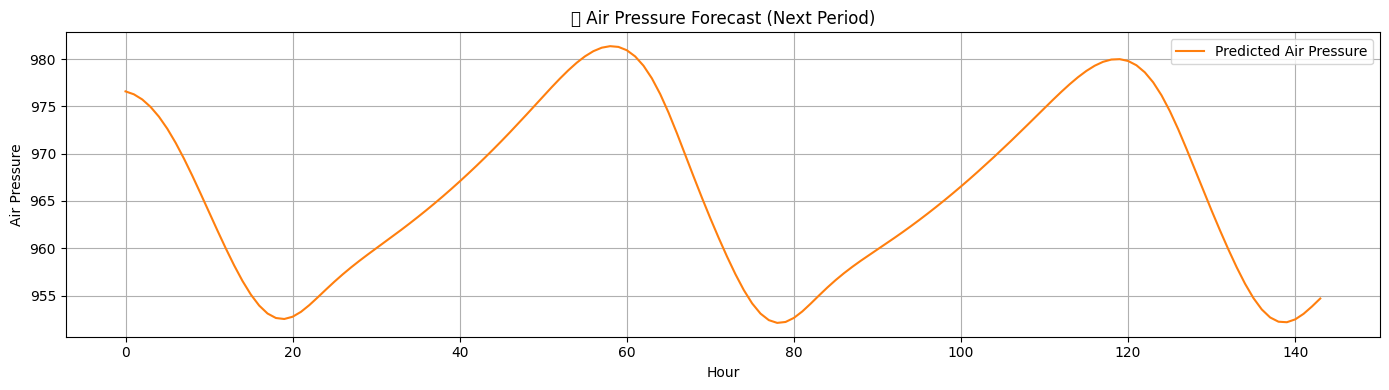

/tmp/ipython-input-52-3353635718.py:88: UserWarning: Glyph 128168 (\N{DASH SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


vmd_forecast shape before sum: (720, 5)


/tmp/ipython-input-52-3353635718.py:89: UserWarning: Glyph 128168 (\N{DASH SYMBOL}) missing from font(s) DejaVu Sans.
  plt.savefig("windspeed.png", dpi = 700)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128168 (\N{DASH SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


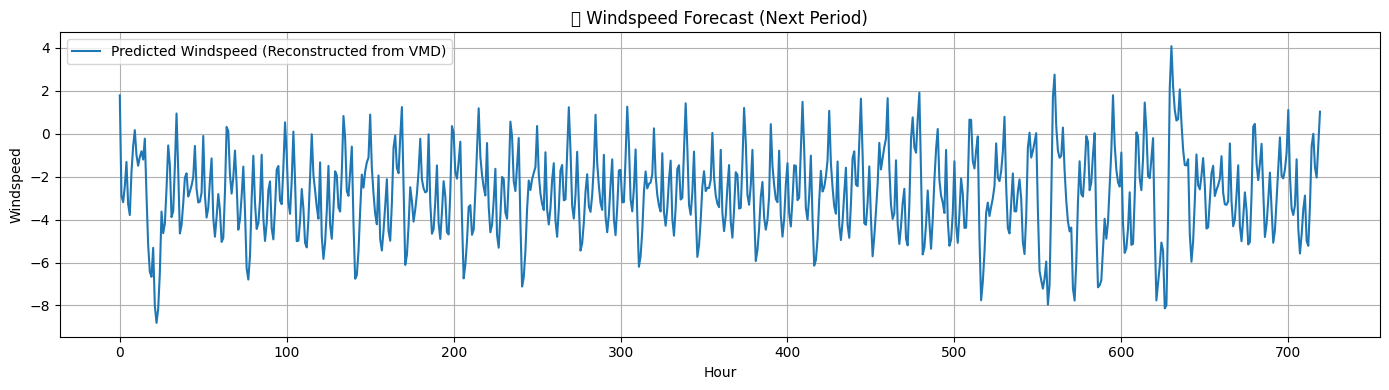


Total blizzards predicted: 1 out of 720 hours

Hour 0010 → Blizzard Probability = 1.00 → ❄️ Blizzard Likely


In [ ]:
blizzard_probs, blizzard_flags, ap_forecast_2mo, ws_forecast_2mo = forecast_2_months_and_detect_blizzards(
    ap_forecast_model, ws_forecast_model, blizzard_prediction_model,
    ap_init, initial_vmd_seq,              # ✅ Pass VMD initial sequence here
    ap_scaler, ws_scaler,
    lookback=lookback_vmd, forecast_hours=720, threshold=0.5
)
